In [46]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

sns.set_style('darkgrid')


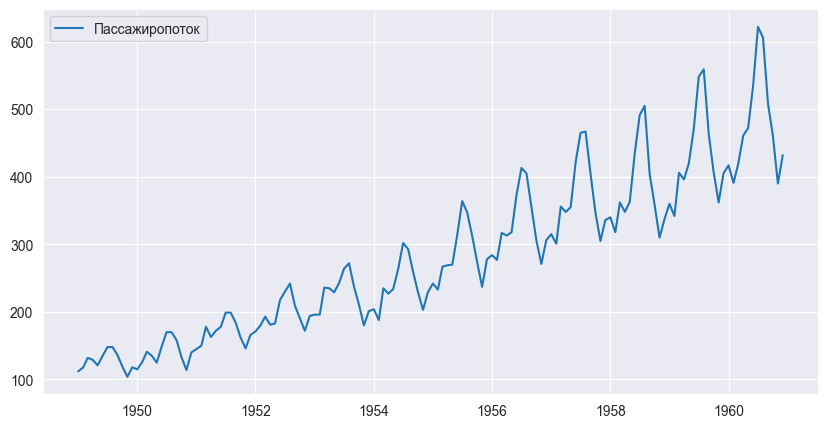

In [47]:
# Загружаем датасет
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, index_col=0, parse_dates=True)

# Визуализируем временной ряд
plt.figure(figsize=(10,5))
plt.plot(df, label="Пассажиропоток")
plt.legend()
plt.show()


In [48]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df.values.reshape(-1, 1))


In [49]:
def create_sequences(data, seq_lenght):
    sequences, labels =[], []
    for i in range(len(data) - seq_lenght):
        sequences.append(data[i:i+seq_lenght])
        labels.append(data[i+seq_lenght])
    return np.array(sequences), np.array(labels)



In [50]:
seq_length = 10
X, y = create_sequences(data, seq_length)

# Разделение на train/test
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Преобразуем в тензоры
X_train_tensors = torch.FloatTensor(X_train)
y_train_tensors = torch.FloatTensor(y_train)
X_test_tensors = torch.FloatTensor(X_test)
y_test_tensors = torch.FloatTensor(y_test)


In [51]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=60, num_layers=3, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout=dropout,
            batch_first = True
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


In [52]:
model = LSTMModel()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

In [53]:
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensors)
    loss = criterion(outputs, y_train_tensors)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss:{loss.item()}')

Epoch 10/200, Loss:0.0461483858525753
Epoch 20/200, Loss:0.03257095441222191
Epoch 30/200, Loss:0.019467171281576157
Epoch 40/200, Loss:0.020339809358119965
Epoch 50/200, Loss:0.011023362167179585
Epoch 60/200, Loss:0.007036490831524134
Epoch 70/200, Loss:0.005611621309071779
Epoch 80/200, Loss:0.005169721785932779
Epoch 90/200, Loss:0.004510066006332636
Epoch 100/200, Loss:0.004260724876075983
Epoch 110/200, Loss:0.004390610381960869
Epoch 120/200, Loss:0.003802606137469411
Epoch 130/200, Loss:0.003180539235472679
Epoch 140/200, Loss:0.0029474066104739904
Epoch 150/200, Loss:0.0027557441499084234
Epoch 160/200, Loss:0.00219472567550838
Epoch 170/200, Loss:0.002231661230325699
Epoch 180/200, Loss:0.0019901057239621878
Epoch 190/200, Loss:0.002353658666834235
Epoch 200/200, Loss:0.0018366406438872218


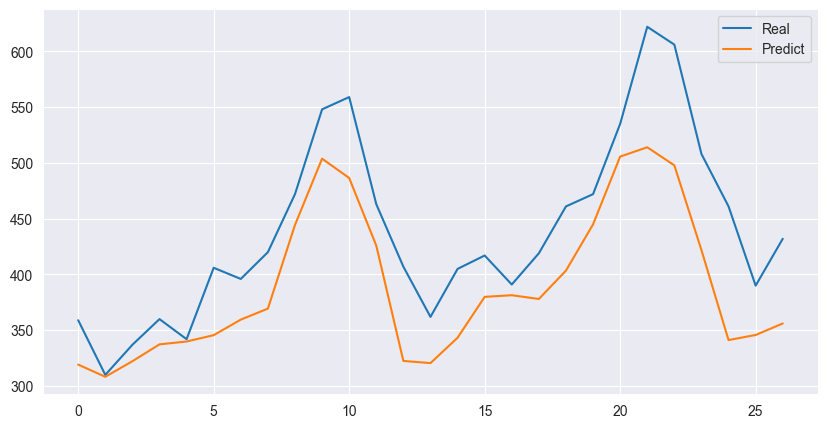

In [54]:
model.eval()

y_pred = model(X_test_tensors).detach().numpy()

plt.figure(figsize=(10, 5))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Real')
plt.plot(scaler.inverse_transform(y_pred), label='Predict')
plt.legend()
plt.show()